In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    f1_score
)
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import torch
import re

2025-11-25 11:50:49.431495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764071449.802276      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764071449.946000      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Configuration

In [2]:
MODEL_NAME = "distilbert-base-cased"
MAX_LENGTH = 512
TRAIN_VAL_SPLIT = 0.15

#hyperparameter
LEARNING_RATE = 3e-5
BATCH_SIZE = 16
EPOCHS = 10
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

#label mapping
LABEL_TO_ID = {"No": 0, "Yes": 1}
ID_TO_LABEL = {0: "No", 1: "Yes"}

#paths
TRAIN_FILE = "/kaggle/input/semeval-2026-psycomark-conspiracy-detection/train_rehydrated.jsonl"
TEST_FILE = "/kaggle/input/semeval-2026-psycomark-conspiracy-detection/dev_rehydrated.jsonl"
OUTPUT_DIR = "./distilbert-conspiracy-cased"

#set seed for reproducibility
SEED = 42

# Text Preprocessing

In [3]:
def preprocess_text(text):
    """
    dataset udah bersih, 
    cuma kita normalize whitespace buat konsistensi.
    """
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load Data

In [4]:
def load_and_filter_data(file_path):
    """Load data and filter out 'Can't tell' labels."""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                item = json.loads(line)
                if 'conspiracy' in item and item['conspiracy'] in ["Yes", "No"]:
                    item['text'] = preprocess_text(item['text'])
                    data.append(item)
            except json.JSONDecodeError:
                continue
    return data

train_data = load_and_filter_data(TRAIN_FILE)

print(f"Loaded samples: {len(train_data)}")

# Class distribution
yes_count = sum(1 for d in train_data if d['conspiracy'] == 'Yes')
no_count = sum(1 for d in train_data if d['conspiracy'] == 'No')
print(f"Yes: {yes_count} ({yes_count/len(train_data)*100:.1f}%)")
print(f"No: {no_count} ({no_count/len(train_data)*100:.1f}%)")
print(f"Imbalance ratio: {max(yes_count, no_count)/min(yes_count, no_count):.2f}:1")

Loaded samples: 3531
Yes: 1541 (43.6%)
No: 1990 (56.4%)
Imbalance ratio: 1.29:1


# Train/Val split

In [5]:
train_texts = [d['text'] for d in train_data]
train_labels = [d['conspiracy'] for d in train_data]

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, 
    train_labels, 
    test_size=TRAIN_VAL_SPLIT,
    stratify=train_labels,
    random_state=SEED
)

print(f"Train: {len(train_texts)}")
print(f"Val: {len(val_texts)}")
print(f"Train Yes%: {train_labels.count('Yes')/len(train_labels)*100:.1f}%")
print(f"Val Yes%: {val_labels.count('Yes')/len(val_labels)*100:.1f}%")

Train: 3001
Val: 530
Train Yes%: 43.7%
Val Yes%: 43.6%


# class weights

In [6]:
# # Compute class weights for imbalanced data
# #class_weights = compute_class_weight(
#     'balanced',
#     classes=np.array([0, 1]),
#     y=np.array([LABEL_TO_ID[label] for label in train_labels])
# )

# class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
# print(f"Class weights: {class_weights_dict}")

# create datasets

In [7]:
train_dataset = Dataset.from_dict({
    'text': train_texts,
    'conspiracy': train_labels
})

val_dataset = Dataset.from_dict({
    'text': val_texts,
    'conspiracy': val_labels
})

# Load Model & Tokenizer

In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

def encode_labels(examples):
    return {'labels': [LABEL_TO_ID[label] for label in examples["conspiracy"]]}

tokenized_train = tokenized_train.map(encode_labels, batched=True)
tokenized_val = tokenized_val.map(encode_labels, batched=True)

print("Tokenization complete")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

Map:   0%|          | 0/3001 [00:00<?, ? examples/s]

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/3001 [00:00<?, ? examples/s]

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Tokenization complete


In [9]:
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=ID_TO_LABEL,
    label2id=LABEL_TO_ID
)

print(f"Model: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: distilbert-base-cased
Parameters: 65,783,042


# define metrics

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    precision_no = np.sum((predictions == 0) & (labels == 0)) / max(np.sum(predictions == 0), 1)
    recall_no = np.sum((predictions == 0) & (labels == 0)) / max(np.sum(labels == 0), 1)
    f1_no = 2 * (precision_no * recall_no) / max(precision_no + recall_no, 1e-8)
    
    precision_yes = np.sum((predictions == 1) & (labels == 1)) / max(np.sum(predictions == 1), 1)
    recall_yes = np.sum((predictions == 1) & (labels == 1)) / max(np.sum(labels == 1), 1)
    f1_yes = 2 * (precision_yes * recall_yes) / max(precision_yes + recall_yes, 1e-8)
    
    accuracy = np.sum(predictions == labels) / len(labels)
    f1_weighted = (f1_no * np.sum(labels == 0) + f1_yes * np.sum(labels == 1)) / len(labels)
    
    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_no': f1_no,
        'f1_yes': f1_yes,
        'precision_no': precision_no,
        'precision_yes': precision_yes,
        'recall_no': recall_no,
        'recall_yes': recall_yes
    }

# training configuration

In [11]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=32,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="linear",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    fp16=True,
    dataloader_num_workers=2,
    seed=SEED
)

# trainingggggg

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Training started")
train_result = trainer.train()
print(f"Training completed - Loss: {train_result.training_loss:.4f}")

/tmp/ipykernel_47/3197963154.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training started


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 No,F1 Yes,Precision No,Precision Yes,Recall No,Recall Yes
1,0.681600,0.593294,0.681132,0.672568,0.741985,0.582716,0.682584,0.678161,0.812709,0.510823
2,0.537600,0.637065,0.692453,0.667898,0.770099,0.535613,0.665854,0.783333,0.913043,0.406926
3,0.372600,0.615748,0.728302,0.716873,0.786350,0.626943,0.706667,0.780645,0.886288,0.523810
4,0.222100,0.667132,0.728302,0.721940,0.778462,0.648780,0.720798,0.743017,0.846154,0.575758
5,0.180200,0.832283,0.726415,0.723580,0.768740,0.665127,0.734756,0.712871,0.806020,0.623377
6,0.106600,0.977992,0.715094,0.706179,0.771558,0.621554,0.704420,0.738095,0.852843,0.536797
7,0.092500,1.266406,0.713208,0.710370,0.757188,0.649770,0.724771,0.694581,0.792642,0.610390
8,0.087900,1.419524,0.716981,0.709972,0.769939,0.632353,0.711048,0.728814,0.839465,0.558442
9,0.078800,1.536563,0.718868,0.712097,0.771121,0.635697,0.713068,0.730337,0.839465,0.562771
10,0.067900,1.640727,0.718868,0.713191,0.768992,0.640964,0.716763,0.722826,0.829431,0.575758


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed - Loss: 0.2387


# Val Evaluation

In [13]:
val_predictions = trainer.predict(tokenized_val)
val_preds = np.argmax(val_predictions.predictions, axis=-1)
val_true = val_predictions.label_ids

print("Validation Results:")
print(classification_report(val_true, val_preds, target_names=['No', 'Yes'], digits=4))

metrics = compute_metrics((val_predictions.predictions, val_true))
print("\nMetrics:")
for key, value in metrics.items():
    print(f"  {key}: {value:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Validation Results:
              precision    recall  f1-score   support

          No     0.7348    0.8060    0.7687       299
         Yes     0.7129    0.6234    0.6651       231

    accuracy                         0.7264       530
   macro avg     0.7238    0.7147    0.7169       530
weighted avg     0.7252    0.7264    0.7236       530


Metrics:
  accuracy: 0.7264
  f1_weighted: 0.7236
  f1_no: 0.7687
  f1_yes: 0.6651
  precision_no: 0.7348
  precision_yes: 0.7129
  recall_no: 0.8060
  recall_yes: 0.6234


# Conf Matrix

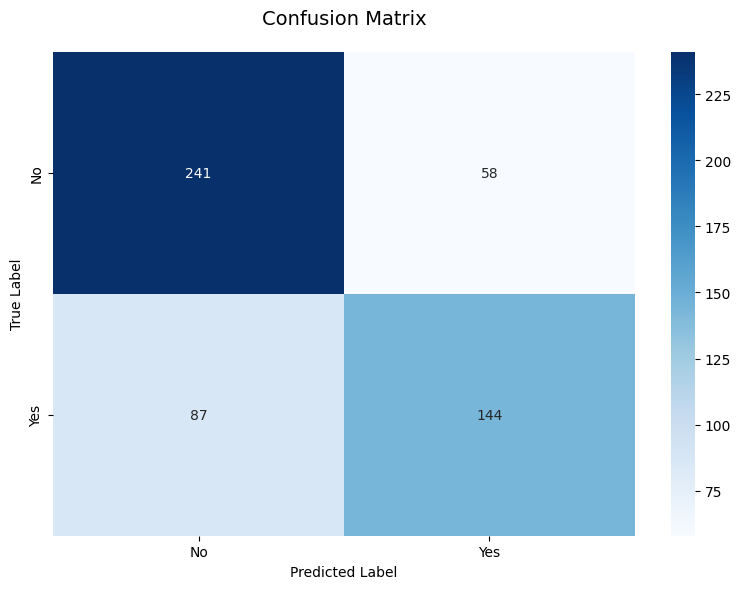

TN: 241 | FP: 58
FN: 87 | TP: 144
FPR: 19.4% | FNR: 37.7%


In [14]:
cm = confusion_matrix(val_true, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"TN: {tn} | FP: {fp}")
print(f"FN: {fn} | TP: {tp}")
print(f"FPR: {fp/(fp+tn)*100:.1f}% | FNR: {fn/(fn+tp)*100:.1f}%")

# kurva ROC

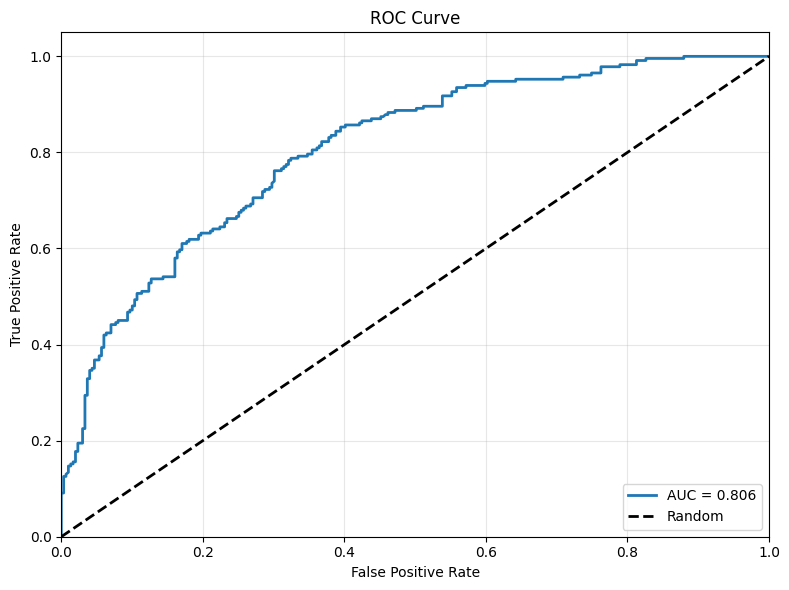

AUC: 0.8063


In [15]:
val_probs = torch.softmax(torch.tensor(val_predictions.predictions), dim=-1)[:, 1].numpy()

fpr, tpr, _ = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC: {roc_auc:.4f}")

# precision, recall

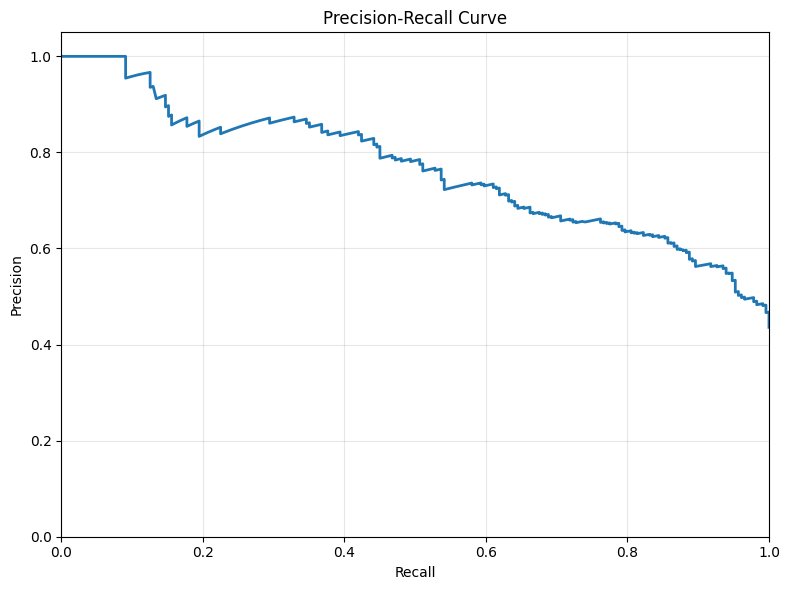

In [16]:
precision, recall, thresholds_pr = precision_recall_curve(val_true, val_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

# threshold optimisasi

Default threshold (0.5): F1 = 0.7236
Optimal threshold (0.585): F1 = 0.7298
Improvement: 0.63%


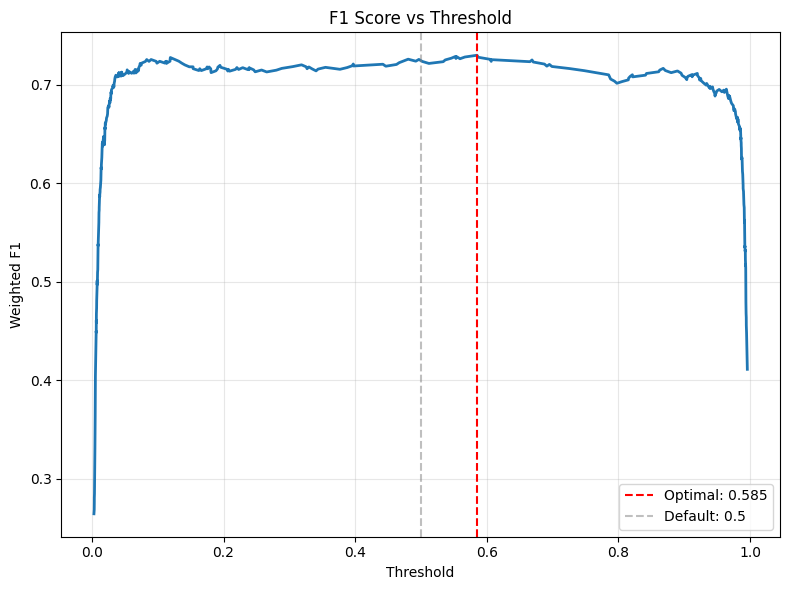

In [17]:
f1_scores = []
for threshold in thresholds_pr:
    preds_at_threshold = (val_probs >= threshold).astype(int)
    f1 = f1_score(val_true, preds_at_threshold, average='weighted')
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

default_f1 = f1_score(val_true, val_preds, average='weighted')

print(f"Default threshold (0.5): F1 = {default_f1:.4f}")
print(f"Optimal threshold ({optimal_threshold:.3f}): F1 = {optimal_f1:.4f}")
print(f"Improvement: {(optimal_f1 - default_f1)*100:.2f}%")

plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, f1_scores, lw=2)
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Default: 0.5')
plt.xlabel('Threshold')
plt.ylabel('Weighted F1')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

OPTIMAL_THRESHOLD = optimal_threshold

# training history

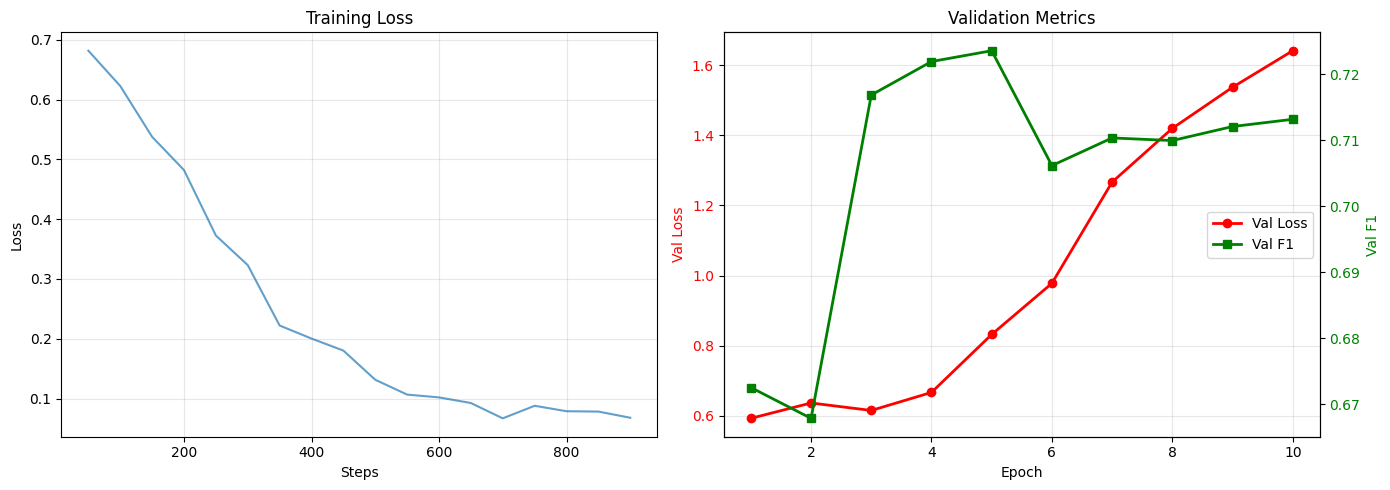

Best epoch: 5
Best val F1: 0.7236


In [18]:
log_history = trainer.state.log_history

train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

train_steps = [log['step'] for log in train_logs]
train_loss = [log['loss'] for log in train_logs]

eval_epochs = [log['epoch'] for log in eval_logs]
eval_loss = [log['eval_loss'] for log in eval_logs]
eval_f1 = [log['eval_f1_weighted'] for log in eval_logs]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_steps, train_loss, alpha=0.7)
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(alpha=0.3)

ax2 = axes[1].twinx()
axes[1].plot(eval_epochs, eval_loss, 'o-', color='red', label='Val Loss', lw=2)
ax2.plot(eval_epochs, eval_f1, 's-', color='green', label='Val F1', lw=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Val Loss', color='red')
ax2.set_ylabel('Val F1', color='green')
axes[1].set_title('Validation Metrics')
axes[1].tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')
axes[1].grid(alpha=0.3)

lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.tight_layout()
plt.show()

best_epoch_idx = np.argmax(eval_f1)
print(f"Best epoch: {int(eval_epochs[best_epoch_idx])}")
print(f"Best val F1: {eval_f1[best_epoch_idx]:.4f}")

# error analysis

In [27]:
val_texts_list = val_texts
val_labels_list = val_labels
misclassified_indices = np.where(val_preds != val_true)[0]

# Ambil indeks asli dari validation set
# Perlu mapping balik ke indeks data original karena sudah di-split
original_labels = [d['conspiracy'] for d in train_data]
train_val_indices = list(range(len(train_data)))

# Split ulang dengan parameter yang sama untuk dapetin indeks val
_, val_indices = train_test_split(
    train_val_indices,
    test_size=TRAIN_VAL_SPLIT,
    stratify=original_labels,  # Pakai label original, bukan train_labels
    random_state=SEED
)

false_positives = [i for i in misclassified_indices if val_preds[i] == 1 and val_true[i] == 0]
false_negatives = [i for i in misclassified_indices if val_preds[i] == 0 and val_true[i] == 1]

print("Error Analysis\n")

if len(false_positives) > 0:
    print("False Positives (Predicted Yes, Actually No):")
    for i in false_positives[:5]:
        original_idx = val_indices[i]
        sample_id = train_data[original_idx].get('_id', 'N/A')
        print(f"  ID: {sample_id}")
        print(f"  Dataset index: {original_idx}")
        print(f"  Text: {val_texts_list[i][:150]}...")
        print(f"  Confidence: {val_probs[i]:.3f}\n")

if len(false_negatives) > 0:
    print("False Negatives (Predicted No, Actually Yes):")
    for i in false_negatives[:5]:
        original_idx = val_indices[i]
        sample_id = train_data[original_idx].get('_id', 'N/A')
        print(f"  ID: {sample_id}")
        print(f"  Dataset index: {original_idx}")
        print(f"  Text: {val_texts_list[i][:150]}...")
        print(f"  Confidence: {1-val_probs[i]:.3f}\n")

Error Analysis

False Positives (Predicted Yes, Actually No):
  ID: t1_eqh38rn
  Dataset index: 1068
  Text: As soon as I read the national weather service's tweet that a massive 80 mile by 80 mile anomaly on their radar was actually a swarm of lady bugs, I k...
  Confidence: 0.815

  ID: t1_gst1qkw
  Dataset index: 369
  Text: Post compares the experimental Covid vaccine with similarly non-sterilizing, “leaky” vaccines? ...We knew this more than fifty years ago; non-steriliz...
  Confidence: 0.666

  ID: t1_gtnnh0o
  Dataset index: 1897
  Text: Who remembers the outcome of this incident where people in Chicago were poisoned from laced Tylenol in Chicago back in '82? In my timeline it was a di...
  Confidence: 0.962

  ID: t1_gtugwwa
  Dataset index: 2821
  Text: poster tries to criticize a Colombian woman by using their own "diverse ethnicity" as a weapon when in fact, they're white and that's easily proven. t...
  Confidence: 0.546

  ID: t1_j9hbvvr
  Dataset index: 1141
  Text: I th

# load test data

In [21]:
def load_test_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            try:
                item = json.loads(line)
                sample_id = item.get("_id", f"sample_{i}")
                text = preprocess_text(item.get("text", ""))
                data.append({
                    "unique_sample_id": sample_id,
                    "text": text
                })
            except json.JSONDecodeError:
                continue
    return data

test_data = load_test_data(TEST_FILE)
test_dataset = Dataset.from_dict({
    'unique_sample_id': [d['unique_sample_id'] for d in test_data],
    'text': [d['text'] for d in test_data]
})

print(f"Test samples: {len(test_data)}")

Test samples: 100


# tokenize test data

In [22]:
unique_ids = test_dataset["unique_sample_id"]

tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test = tokenized_test.remove_columns(["unique_sample_id", "text"])

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# predictttctcttctct

In [23]:
prediction_trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./tmp_inference",
        per_device_eval_batch_size=64,
        report_to="none"
    ),
    data_collator=data_collator
)

predictions_output = prediction_trainer.predict(tokenized_test)

logits = predictions_output.predictions
probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

predicted_class_ids = (probs >= OPTIMAL_THRESHOLD).astype(int)
predicted_labels = [ID_TO_LABEL[int(id)] for id in predicted_class_ids]

print(f"Predictions: {len(predicted_labels)}")
print(f"Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"Predicted Yes: {sum(predicted_class_ids)} ({sum(predicted_class_ids)/len(predicted_labels)*100:.1f}%)")

Predictions: 100
Threshold: 0.585
Predicted Yes: 32 (32.0%)


# bikin submission

In [24]:
jsonl_lines = []
for i, label in enumerate(predicted_labels):
    jsonl_obj = {"_id": unique_ids[i], "conspiracy": label}
    jsonl_lines.append(json.dumps(jsonl_obj))

with open("submission.jsonl", 'w') as f:
    f.write('\n'.join(jsonl_lines) + '\n')

print(f"Submission file created: {len(predicted_labels)} predictions")

Submission file created: 100 predictions


In [25]:
import zipfile

with zipfile.ZipFile("submission.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("submission.jsonl")

print("submission.zip created")

submission.zip created


In [26]:
#donlod submisson
from IPython.display import FileLink
FileLink(r'submission.zip')

/kaggle/working/submission.zip